# Evaluierung

# Set up

In [ ]:
!pip install -q qdrant-client
!pip install -q ranx

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from io import BytesIO
from qdrant_client import QdrantClient
from qdrant_client.http import models
from IPython.display import display
from io import BytesIO
import base64
from PIL import Image
import torch
import cv2
import numpy as np
from pathlib import Path
from typing import List, Dict
from tqdm import tqdm
import json
import os

def encode_base64_image(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return str(base64.b64encode(buffered.getvalue()), "utf-8")


def decode_base64_image(base64_string):
    # Decode the base64 string into bytes
    image_data = base64.b64decode(base64_string)

    # Convert the bytes back into an image
    buffered = BytesIO(image_data)
    image = Image.open(buffered)

    return image


def resize_image(image, max_height=800):
    width, height = image.size
    if height > max_height:
        ratio = max_height / height
        new_width = int(width * ratio)
        new_height = int(height * ratio)
        return image.resize((new_width, new_height))
    return image


def save_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def combine_json_files(directory: str):
    combined_data = []

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            data = load_json(file_path)
            combined_data.extend(data)

    return combined_data

def convert_sparse_output(sparse_output):
    sparse_transformed = []
    for dic in sparse_output:
        result = {"values": [], "indices": []}
        for idx, val in dic.items():
            result["values"].append(val)
            result["indices"].append(int(idx))
        sparse_transformed.append(result)
    return sparse_transformed

In [ ]:
# coding=utf-8
# Copyright 2024 The GTE Team Authors and Alibaba Group.
# Licensed under the Apache License, Version 2.0 (the "License");

from collections import defaultdict
from typing import Dict, List, Tuple

import numpy as np
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers.utils import is_torch_npu_available


class GTEEmbeddidng(torch.nn.Module):
    def __init__(self,
                 model_name: str = None,
                 normalized: bool = True,
                 use_fp16: bool = True,
                 device: str = None
                ):
        super().__init__()
        self.normalized = normalized
        if device:
            self.device = torch.device(device)
        else:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
            elif torch.backends.mps.is_available():
                self.device = torch.device("mps")
            elif is_torch_npu_available():
                self.device = torch.device("npu")
            else:
                self.device = torch.device("cpu")
                use_fp16 = False
        self.use_fp16 = use_fp16
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(
            model_name, trust_remote_code=True, torch_dtype=torch.float16 if self.use_fp16 else None
        )
        self.vocab_size = self.model.config.vocab_size
        self.model.to(self.device)

    def _process_token_weights(self, token_weights: np.ndarray, input_ids: list):
        result = defaultdict(int)
        unused_tokens = {self.tokenizer.cls_token_id, self.tokenizer.eos_token_id,
                        self.tokenizer.pad_token_id, self.tokenizer.unk_token_id}

        for w, idx in zip(token_weights, input_ids):
            idx = int(idx)
            if idx not in unused_tokens and w > 0:
                if w > result[idx]:
                    result[idx] = w
        return {
            "values": list(result.values()),
            "indices": list(result.keys())
        }

    @torch.no_grad()
    def encode(self,
               texts: None,
               dimension: int = None,
               max_length: int = 8192,
               batch_size: int = 16,
               return_dense: bool = True,
               return_sparse: bool = False):
        if dimension is None:
            dimension = self.model.config.hidden_size
        if isinstance(texts, str):
            texts = [texts]
        num_texts = len(texts)
        all_dense_vecs = []
        all_token_weights = []
        for n, i in enumerate(range(0, num_texts, batch_size)):
            batch = texts[i: i + batch_size]
            results = self._encode(batch, dimension, max_length, batch_size, return_dense, return_sparse)
            if return_dense:
                all_dense_vecs.append(results['dense_embeddings'])
            if return_sparse:
                all_token_weights.extend(results['token_weights'])
        if return_dense:
            all_dense_vecs = torch.cat(all_dense_vecs, dim=0)

        return {
            "dense_embeddings": all_dense_vecs if return_dense else None,
            "token_weights": all_token_weights if return_sparse else None
        }

    @torch.no_grad()
    def _encode(self,
                texts: Dict[str, torch.Tensor] = None,
                dimension: int = None,
                max_length: int = 1024,
                batch_size: int = 16,
                return_dense: bool = True,
                return_sparse: bool = False):

        text_input = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
        text_input = {k: v.to(self.model.device) for k,v in text_input.items()}
        model_out = self.model(**text_input, return_dict=True)

        output = {}
        if return_dense:
            dense_vecs = model_out.last_hidden_state[:, 0, :dimension]
            if self.normalized:
                dense_vecs = torch.nn.functional.normalize(dense_vecs, dim=-1)
            output['dense_embeddings'] = dense_vecs
        if return_sparse:
            token_weights = torch.relu(model_out.logits).squeeze(-1)
            token_weights = [
                self._process_token_weights(weights, input_ids)
                for weights, input_ids in zip(
                    token_weights.detach().cpu().numpy().tolist(),
                    text_input['input_ids'].cpu().numpy().tolist()
                )
            ]
            output['token_weights'] = token_weights

        return output

    def _compute_sparse_scores(self, emb1, emb2):
        scores = 0
        emb2_lookup = {idx: val for idx, val in zip(emb2["indices"], emb2["values"])}
        for idx, weight in zip(emb1["indices"], emb1["values"]):
            if idx in emb2_lookup:
                scores += weight * emb2_lookup[idx]
        return scores

    def compute_sparse_scores(self, embs1, embs2):
        scores = [self._compute_sparse_scores(emb1, emb2) for emb1, emb2 in zip(embs1, embs2)]
        return np.array(scores)

    def compute_dense_scores(self, embs1, embs2):
        scores = torch.sum(embs1*embs2, dim=-1).cpu().detach().numpy()
        return scores

    @torch.no_grad()
    def compute_scores(self,
        text_pairs: List[Tuple[str, str]],
        dimension: int = None,
        max_length: int = 1024,
        batch_size: int = 16,
        dense_weight=1.0,
        sparse_weight=0.1):
        text1_list = [text_pair[0] for text_pair in text_pairs]
        text2_list = [text_pair[1] for text_pair in text_pairs]
        embs1 = self.encode(text1_list, dimension, max_length, batch_size, return_dense=True, return_sparse=True)
        embs2 = self.encode(text2_list, dimension, max_length, batch_size, return_dense=True, return_sparse=True)
        scores = self.compute_dense_scores(embs1['dense_embeddings'], embs2['dense_embeddings']) * dense_weight + \
            self.compute_sparse_scores(embs1['token_weights'], embs2['token_weights']) * sparse_weight
        scores = scores.tolist()
        return scores

model_name_or_path = 'Alibaba-NLP/gte-multilingual-base'
sparse_dense_model = GTEEmbeddidng(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/611M [00:00<?, ?B/s]

In [ ]:
apikey_chunks = ""
collection_chunks = "manuals-with-ocr"
apikey_pages = ""
collection_pages = "manuals-with-markdown"

client_chunks = QdrantClient(
     url="https://c1c6b76d-3e82-4265-8850-542922eeb4b9.us-east4-0.gcp.cloud.qdrant.io:6333/dashboard#/collections",
     api_key=apikey_chunks,
 )
client_pages = QdrantClient(
    url="https://568e9069-f3eb-4ee2-8e22-52e7bad7d3b7.europe-west3-0.gcp.cloud.qdrant.io:6333",
    api_key=apikey_pages,
)

In [ ]:
client_pages.scroll(collection_pages, limit =1)

([Record(id=1, payload={'title': 'MiR 24V Battery Troubleshooting and Technical Guide 2.1_en', 'page_number': 1, 'text': '\n\n## MiR 24V Battery Troubleshooting and Technical Guide\n\nDate: 06/2024\n\nVersion: 2.1 (en)\n', 'headings': [['MiR 24V Battery Troubleshooting and Technical Guide', 0]], 'label': 'manual', 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKAAcQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5Ok

# Query loading and preprocessing

Building Ground Truth

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Evaluation/Testfragen(Fragen).csv", delimiter =";", encoding="latin1")
#df = pd.read_csv("Testfragen.csv", encoding="utf-8", delimiter =";")

In [ ]:
queries_same_language = df[df["Language"].astype(str) == df["Document Language"].astype(str)]
queries_precise = queries_same_language[queries_same_language["Type"].astype(str) == "Precise"]
queries_ambigious = queries_same_language[queries_same_language["Type"].astype(str) == "Ambigious"]
queries_ultraprecise = queries_same_language[queries_same_language["Type"].astype(str) == "Ultraprecise"]
queries_english = queries_same_language[queries_same_language["Document Language"].astype(str) == "en"]
queries_german = queries_same_language[queries_same_language["Document Language"].astype(str) == "de"]

In [ ]:
# only english documents in dbs for now
queries = queries_english

In [ ]:
import json

with open("/content/drive/MyDrive/ocr-markdown/new-ids.json", "r") as file:
     data = json.load(file)

#with open("pages-ids.json", "r") as file:
#    data = json.load(file)

def get_id_by_title_and_page(title, page_number):
    for item in data:
        if item['title'] == title and item['page_number'] == page_number:
            return item['id']
    return None

In [ ]:
from ranx import Qrels
from collections import defaultdict

qrels_dict = defaultdict(dict)
queries_lookup = dict()

for _, row in queries.iterrows():
      query_id = str(row["ID"])
      document_name = str(row["Relevant Document"])
      optimal_page = row["Optimal Page"]

      page_id = get_id_by_title_and_page(document_name, optimal_page)
      if page_id is None:
              break
      queries_lookup[query_id] = (str(row["Question"]),page_id)


      score = 1
      qrels_dict[str(query_id)][str(page_id)] = score

qrels = Qrels(qrels_dict, name=collection_pages)

queries_lookup, qrels

({'34.0': ('What steps are required to reactivate a battery in DeepSleep?',
   18),
  '35.0': ('How can I reactivate a battery that is not working?', 18),
  '36.0': ('What to do if the battery does not charge?', 18),
  '40.0': ('What does the error message \x93Localization error\x94 mean?',
   751),
  '41.0': ('Why has my MiR robot suddenly stopped navigating?', 751),
  '42.0': ('What should I do if a MiR robot cannot plan a safe route?', 751),
  '46.0': ('My robot suddenly shuts down. How can I fix the problem?', 62),
  '47.0': ("My robot suddenly stops working even though it hasn't had any problems in the last few days. Maybe a problem with the battery?",
   62),
  '48.0': ('The robot suddenly stops working out of the blue. What can I do?',
   62),
  '52.0': ('What does error code 503 mean for a MiR battery?', 64),
  '53.0': ('How do I rectify error code 503 on my MiR robot?', 64),
  '54.0': ('What should I do if the battery is not sending any charging messages?',
   64),
  '58.0': (

Embedding der Queries

In [ ]:
from tqdm import tqdm

sparse_vectors = []
dense_vectors = []

# Calculate number of batches
batch_size = 5
n_samples = len(queries)
n_batches = (n_samples + batch_size - 1) // batch_size

# Process in batches
for batch_idx in tqdm(range(n_batches)):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, n_samples)

    # Get batch of queries
    batch_queries = queries.iloc[start_idx:end_idx]["Question"].astype(str).tolist()

    # Generate sparse and dense vectors for batch
    batch_vectors = sparse_dense_model.encode(
        batch_queries,
        return_sparse=True,
        return_dense=True
    )

    # Process sparse vectors
    sparse_vectors.extend(batch_vectors["token_weights"])

    # Process dense vectors - simplified to handle flat structure
    batch_dense = [embed.tolist() for embed in batch_vectors["dense_embeddings"]]
    dense_vectors.extend(batch_dense)




100%|██████████| 7/7 [00:00<00:00, 24.45it/s]


In [ ]:
import torch
from typing import Dict, List, Union

def embed_single_query(
    query: str
) -> Dict[str, Union[List[float], List[List[float]]]]:

    # Generate sparse and dense vectors
    vectors = sparse_dense_model.encode(
        [query],  # Wrap single query in list
        return_sparse=True,
        return_dense=True
    )

    # Extract sparse and dense vectors
    sparse_vector = vectors["token_weights"][0]  # Get first (only) item
    dense_vector = vectors["dense_embeddings"][0].tolist()  # Convert to list

    return {
        "sparse_vector": sparse_vector,
        "dense_vector": dense_vector
    }

# Code for evaluation

In [ ]:
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Iterator, Tuple
from ranx import Run, evaluate, compare
from qdrant_client import models
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets

@dataclass
class QueryVector:
    dense: Any
    sparse: dict
    query_id: str

@dataclass
class RunWithPayloads:
    run: Run
    payloads: Dict[str, List[Dict[str, Any]]]
    llm_evaluation: Optional[Dict[str, float]] = None

class Engine:
    def __init__(self, client, collection, queries: Dict[str, Tuple[str, str]], qrels, metrics=None, chunked=False):
        self.client = client
        self.collection = collection
        self.queries = queries  # {query_id: (text, solution_id)}
        self.qrels = qrels
        self.metrics = metrics or ["precision@1", "hit_rate@5", "mrr@5"]
        self.runs: Dict[str, RunWithPayloads] = {}
        self.chunked = chunked

    def create_run(self, name: str, run_dict: Dict[str, Dict[str, float]], payloads_dict: Dict[str, List[Dict[str, Any]]]) -> RunWithPayloads:
        run = Run(run_dict, name=name)
        run_with_payloads = RunWithPayloads(run=run, payloads=payloads_dict)
        self.runs[name] = run_with_payloads
        return run_with_payloads

    def evaluate_run(self, run_name: str, llm=True, top_k=5) -> float:
        """Evaluate a single run"""

        return evaluate(self.qrels, self.runs[run_name].run, metrics=self.metrics, make_comparable=True)

    def compare_runs(self, run_names: Optional[List[str]] = None) -> str:
        runs_to_compare = [self.runs[name].run for name in (run_names or self.runs.keys())]
        return compare(
            qrels=self.qrels,
            runs=runs_to_compare,
            metrics=self.metrics,
            rounding_digits=3,
            show_percentages=True,
            make_comparable=True
        )

    def basic_search_run(self, query_vectors: List[QueryVector], using: str, name: str, final_limit: int = 5) -> RunWithPayloads:
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.basic_search(qv, using, final_limit)
            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def basic_search(self, qv: QueryVector, using: str, final_limit: int = 5):
        query_vector = self._get_query_vector(qv, using)
        results = self.client.query_points(
            self.collection,
            query=query_vector,
            using=using,
            with_payload=True,
            limit=final_limit
        )

        if self.chunked:
            return self._aggregate_chunked_results(results)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
            return scores_dict, query_payloads

    def rrf_fusion_search_run(self, query_vectors: List[QueryVector], methods: List[str], name: str, prefetch_limit: int = 50, final_limit: int = 5) -> RunWithPayloads:
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.rrf_fusion_search(qv, methods, prefetch_limit, final_limit)
            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def rrf_fusion_search(self, qv: QueryVector, methods: List[str], prefetch_limit: int = 50, final_limit: int = 5):
        prefetch = [
            models.Prefetch(
                query=self._get_query_vector(qv, method),
                using=method,
                limit=prefetch_limit
            )
        for method in methods]

        results = self.client.query_points(
            self.collection,
            prefetch=prefetch,
            query=models.FusionQuery(fusion=models.Fusion.RRF),
            with_payload=True,
            limit=final_limit,
        )

        if self.chunked:
            return self._aggregate_chunked_results(results)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
            return scores_dict, query_payloads

    def reranking_search_run(
        self,
        query_vectors: List[QueryVector],
        prefetch_method: str,
        rerank_method: str,
        name: str,
        prefetch_limit: int = 30,
        final_limit: int = 5
    ) -> RunWithPayloads:
        """Perform a run with reranking search"""
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.reranking_search(qv, prefetch_method, rerank_method, prefetch_limit, final_limit)
            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def reranking_search(self, qv: QueryVector, prefetch_method: str, rerank_method: str, prefetch_limit: int = 30, final_limit: int = 5):
        prefetch = [
            models.Prefetch(
                query=self._get_query_vector(qv, prefetch_method),
                using=prefetch_method,
                limit=prefetch_limit
            )
        ]

        results = self.client.query_points(
            self.collection,
            prefetch=prefetch,
            using=rerank_method,
            query=self._get_query_vector(qv, rerank_method),
            with_payload=True,
            limit=final_limit,
        )

        if self.chunked:
            return self._aggregate_chunked_results(results)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
            return scores_dict, query_payloads

    def nested_prefetch_search_run(self, query_vectors: List[QueryVector], primary_method: str, secondary_prefetch_methods: List[str], name: str, primary_limit: int = 20, secondary_limit: int = 50, final_limit: int = 5) -> RunWithPayloads:
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.nested_prefetch_search(qv, primary_method, secondary_prefetch_methods, primary_limit, secondary_limit, final_limit)
            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def nested_prefetch_search(self, qv: QueryVector, primary_method: str, secondary_prefetch_methods: List[str], primary_limit: int = 20, secondary_limit: int = 50, final_limit: int = 5):
        inner_prefetch = [
            models.Prefetch(
                query=self._get_query_vector(qv, method),
                using=method,
                limit=secondary_limit
            )
            for method in secondary_prefetch_methods
        ]

        prefetch = [
            models.Prefetch(
                prefetch=inner_prefetch,
                query=self._get_query_vector(qv, primary_method),
                using=primary_method,
                limit=primary_limit
            )
        ]

        results = self.client.query_points(
            self.collection,
            prefetch=prefetch,
            query=self._get_query_vector(qv, "multi"),
            using="multi",
            with_payload=True,
            limit=final_limit
        )

        if self.chunked:
            return self._aggregate_chunked_results(results)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
            return scores_dict, query_payloads

    def dbsf_fusion_search_run(
        self,
        query_vectors: List[QueryVector],
        methods: List[str],
        name: str,
        prefetch_limit: int = 50,
        final_limit: int = 5
    ) -> RunWithPayloads:
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.dbsf_fusion_search(qv, methods, prefetch_limit, final_limit)
            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def dbsf_fusion_search(
        self,
        qv: QueryVector,
        methods: List[str],
        prefetch_limit: int = 50,
        final_limit: int = 5
    ):
        prefetch = [
            models.Prefetch(
                query=self._get_query_vector(qv, method),
                using=method,
                limit=prefetch_limit
            )
            for method in methods
        ]

        # DBSF fusion with no weights or fusion_params
        fusion_query = models.FusionQuery(
            fusion=models.Fusion.DBSF
        )

        results = self.client.query_points(
            self.collection,
            prefetch=prefetch,
            query=fusion_query,
            with_payload=True,
            limit=final_limit,
        )

        if self.chunked:
            return self._aggregate_chunked_results(results)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
            return scores_dict, query_payloads


    def fusion_reranking_search_run(
        self,
        query_vectors: List[QueryVector],
        methods: List[str],
        fusion_type: models.Fusion,
        rerank_method: str,
        name: str,
        weights: Optional[List[float]] = None,
        prefetch_limit: int = 50,
        final_limit: int = 5
    ) -> RunWithPayloads:
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.fusion_reranking_search(
                qv, methods, fusion_type, rerank_method, weights, prefetch_limit, final_limit
            )
            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def fusion_reranking_search(
        self,
        qv: QueryVector,
        methods: List[str],
        fusion_type: models.Fusion,
        rerank_method: str,
        weights: Optional[List[float]] = None,  # no longer needed, but can remain optional if you want
        prefetch_limit: int = 50,
        final_limit: int = 5
    ) -> Tuple[Dict[str, float], List[Dict[str, Any]]]:

        inner_prefetch = [
            models.Prefetch(
                query=self._get_query_vector(qv, method),
                using=method,
                limit=prefetch_limit
            )
            for method in methods
        ]

        # Now we do not supply weights even for DBSF:
        fusion_query = models.FusionQuery(fusion=fusion_type)

        prefetch = [
            models.Prefetch(
                prefetch=inner_prefetch,
                query=fusion_query,
                limit=prefetch_limit
            )
        ]

        results = self.client.query_points(
            self.collection,
            prefetch=prefetch,
            using=rerank_method,
            query=self._get_query_vector(qv, rerank_method),
            with_payload=True,
            limit=final_limit
        )

        if self.chunked:
            return self._aggregate_chunked_results(results)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
            return scores_dict, query_payloads


    def _get_query_vector(self, query_vector: QueryVector, method: str) -> Any:
        if method == "dense":
            return query_vector.dense
        elif method == "sparse":
            return models.SparseVector(**query_vector.sparse)
        else:
            raise ValueError(f"Unknown method: {method}")

    def inspect_run(self, run_name: str, top_k=5) -> None:
        """
        Interactive inspection of search results using IPython widgets.
        Uses saved payloads instead of making client calls.

        This method references external functions and variables that are not provided
        in the snippet (like `client_pages`, `collection_pages`, `get_id_by_title_and_page`, etc.).
        Adjust as needed.
        """
        run_with_payloads = self.runs[run_name]
        queries_iterator = self._get_queries_iterator()

        # The following code references external functions like `client_pages` or `create_result_html`.
        # Assuming these are defined elsewhere.

        all_correct_ids = {int(correct_id) for _, (_, correct_id) in queries_iterator}
        id_to_db_entry = {
            entry.id: entry
            for entry in client_pages.retrieve(collection_pages, list(all_correct_ids))
        }

        # Reset iterator after pre-fetching
        queries_iterator = self._get_queries_iterator()

        def display_results() -> None:
            clear_output(wait=True)
            display(next_button)

            query_id, (query_text, correct_id) = next(queries_iterator)
            display(HTML(f'<div style="margin: 10px 0;"><strong>Query:</strong> {query_text}</div>'))

            correct_id = int(correct_id)
            db_entry = id_to_db_entry[correct_id]
            is_relevant = str(correct_id) in run_with_payloads.run[query_id]
            llm_score = run_with_payloads.llm_evaluation[query_id] if run_with_payloads.llm_evaluation else "-"

            html_output = ['<div style="margin: 20px 0;">']
            html_output.append('<h3>Correct Page:</h3>')
            if "image" in db_entry.payload:
                img_data = db_entry.payload["image"]
                correct_page_html = '<div style="display: flex; min-height: 60vh; align-items: center;">'
                correct_page_html += f'''
                    <div style="flex: 0 0 400px;">
                        <img src="data:image/jpeg;base64,{img_data}" style="max-width: 400px; height: auto;"/>
                    </div>
                    <div style="flex: 1; align-self: flex-start; padding-top: 20px; margin-left: 20px;">
                        <p><strong>Relevant page retrieved:</strong> {is_relevant}</p>
                        <p><strong>LLM-score:</strong> {llm_score}</p>
                    </div>
                '''
                correct_page_html += '</div>'
                html_output.append(correct_page_html)

            html_output.append('<h3>Search Results:</h3>')
            for doc_payload in run_with_payloads.payloads[query_id][:top_k]:
                html_output.append(create_result_html(doc_payload))

            display(HTML('\n'.join(html_output)))

        next_button = widgets.Button(description='Next Query')
        next_button.on_click(lambda _: display_results())
        display_results()

    def _get_queries_iterator(self) -> Iterator[Tuple[str, Tuple[str, str]]]:
        return iter(self.queries.items())

    def _aggregate_chunked_results(self, results):
        # Dictionary to store first occurrence of each unique page
        first_occurrences = {}
        # Dictionary to store aggregated text chunks for each unique page
        text_chunks = {}
        # Dictionary to store scores (will use score from first chunk)
        scores_dict = {}

        for point in results.points:
            page_id = str(get_id_by_title_and_page(point.payload["title"], point.payload["page_number"]))

            # If this is the first time we see this page_id
            if page_id not in first_occurrences:
                # Store the complete payload of the first chunk
                first_occurrences[page_id] = point.payload
                # Initialize text chunks list
                text_chunks[page_id] = []
                # Store the score from the first chunk
                scores_dict[page_id] = point.score

            # Always append the text chunk
            if "text" in point.payload:
                text_chunks[page_id].append(point.payload["text"])

        # Create final payloads list while preserving order from results
        seen_pages = set()
        query_payloads = []

        for point in results.points:
            page_id = str(get_id_by_title_and_page(point.payload["title"], point.payload["page_number"]))

            # Only add each unique page once while preserving the order
            if page_id not in seen_pages:
                seen_pages.add(page_id)

                # Start with the first occurrence's payload
                final_payload = dict(first_occurrences[page_id])

                # Replace text with aggregated chunks
                final_payload["text"] = "\n".join(text_chunks[page_id])

                query_payloads.append(final_payload)

        return scores_dict, query_payloads


def prepare_query_vectors(
    queries: Dict[str, Tuple[str, str]],
    dense_vectors: List[Any],
    sparse_vectors: List[dict],
) -> List[QueryVector]:
    return [
        QueryVector(
            dense=dense_vectors[i],
            sparse=sparse_vectors[i],
            query_id=query_id
        )
        for i, (query_id, _) in enumerate(queries.items())
    ]

def compare_runs_from_multiple_engines(engines: List[Engine], metrics: List[str] = None) -> str:
    if not metrics:
        metrics = engines[0].metrics
    qrels = engines[0].qrels

    seen_names = set()
    runs_to_compare = []
    for engine in engines:
        for name in engine.runs.keys():
            if name in seen_names:
                raise ValueError(f"Duplicate run name found: '{name}'. All run names must be unique across engines.")
            seen_names.add(name)
            runs_to_compare.append(engine.runs[name].run)

    return compare(
        qrels=qrels,
        runs=runs_to_compare,
        metrics=metrics,
        rounding_digits=3,
        show_percentages=True,
    )

def display_result(query_text, query_payloads, top_k=5) -> None:
    display(HTML(f'<div style="margin: 10px 0;"><strong>Query:</strong> {query_text}</div>'))
    html_output = ['<div style="margin: 20px 0;">']

    html_output.append('<h3>Search Results:</h3>')
    for doc_payload in query_payloads[:top_k]:
        html_output.append(create_result_html(doc_payload))

    display(HTML('\n'.join(html_output)))

def create_result_html(doc_payload, chunked=False):
    styles = '''
        <style>
            .path {
                font-family: system-ui;
                line-height: 1.5;
                margin: 10px 0;
            }
            .path-item {
                margin-left: 20px;
            }
            .path-arrow {
                color: #666;
                margin: 0 8px;
            }
        </style>
    '''

    html = styles + '<div style="display: flex; align-items: start; margin-bottom: 20px; border-bottom: 1px solid #ccc; padding-bottom: 20px;">'

    if "image" in doc_payload:
        img_data = doc_payload["image"]
        html += f'''
            <div style="flex: 0 0 400px;">
                <img src="data:image/jpeg;base64,{img_data}" style="max-width: 400px; height: auto;"/>
            </div>
        '''

    html += '<div style="flex: 1; margin-left: 20px;">'
    if "label" in doc_payload:
        html += f'<p><strong>Label:</strong> {doc_payload["label"]}</p>'
    if "title" in doc_payload:
        html += f'<p><strong>Title:</strong> {doc_payload["title"]}</p>'
    if "page_number" in doc_payload:
        html += f'<p><strong>Page:</strong> {doc_payload["page_number"]}</p>'
    if "headings" in doc_payload:
        headings = doc_payload["headings"]
        html += '<p><strong>Headings:</strong></p>'
        html += '<div class="path">'
        current_level = -1
        open_divs = 0
        for title, level in headings:
            while current_level >= level:
                html += '</div>'
                open_divs -= 1
                current_level -= 1
            if level > 0:
                html += '<div class="path-item">'
                html += f'<span class="path-arrow">-></span>'
                open_divs += 1
            html += f'<span>{title}</span>'
            current_level = level
        html += '</div>' * open_divs
        html += '</div>'
    if "text" in doc_payload:
        html += f'<p><strong>Text:</strong> {doc_payload["text"]}</p>'

    html += '</div>'
    html += '</div>'
    return html


# Usage

## Pages collection

In [ ]:
# Initialize the engine
engine_pages = Engine(
    client=client_pages,
    collection=collection_pages,
    queries=queries_lookup,
    qrels=qrels
)

# Prepare query vectors
query_vectors_pages = prepare_query_vectors(
    queries=queries_lookup,
    dense_vectors=dense_vectors,
    sparse_vectors=sparse_vectors,
)

# Basic searches
engine_pages.basic_search_run(query_vectors_pages, using="sparse", name="Sparse - Markdown")
engine_pages.basic_search_run(query_vectors_pages, using="dense", name="Dense - Markdown")

# RRF searches
engine_pages.rrf_fusion_search_run(
    query_vectors_pages,
    methods=["dense", "sparse"],
    name="Dense & Sparse(RRF) - Markdown"
)

# dbsf
engine_pages.dbsf_fusion_search_run(query_vectors_pages, ["dense", "sparse"], "Dense & Sparse(DBSF) - Markdown")

# Reranking searches
engine_pages.reranking_search_run(
    query_vectors_pages,
    prefetch_method="dense",
    rerank_method="sparse",
    name="Dense & Sparse(Reranker) - Markdown"
)

# Reranking searches
engine_pages.reranking_search_run(
    query_vectors_pages,
    prefetch_method="sparse",
    rerank_method="dense",
    name="Sparse & Dense(Reranker) - Markdown"
)

# Compare all runs
report = engine_pages.compare_runs()
print(report)

#    Model                                  P@1    Hit Rate@5    MRR@5
---  -----------------------------------  -----  ------------  -------
a    Sparse - Markdown                     21.9          40.6     29.3
b    Dense - Markdown                      15.6          59.4     30.9
c    Dense & Sparse(RRF) - Markdown        21.9          46.9     32
d    Dense & Sparse(DBSF) - Markdown       28.1          40.6     33.9
e    Dense & Sparse(Reranker) - Markdown   21.9          43.8     30.1
f    Sparse & Dense(Reranker) - Markdown   15.6          53.1     28.9


## OCR collection

In [ ]:
# Initialize the engine
engine_chunks = Engine(
    client=client_chunks,
    collection=collection_chunks,
    queries=queries_lookup,
    qrels=qrels,
    chunked=False
)

# Prepare query vectors
query_vectors_chunks = prepare_query_vectors(
    queries=queries_lookup,
    dense_vectors=dense_vectors,
    sparse_vectors=sparse_vectors,
)

# aggregation of chunks to pages -> bigger final_limit
# Basic searches
engine_chunks.basic_search_run(query_vectors_chunks, using="sparse", name="Sparse - OCR")
engine_chunks.basic_search_run(query_vectors_chunks, using="dense", name="Dense - OCR")


# df (and reranking)
engine_chunks.dbsf_fusion_search_run(query_vectors_chunks, ["dense", "sparse"], "Dense & Sparse(DBSF) - OCR")


# RRF fusion searches
engine_chunks.rrf_fusion_search_run(
    query_vectors_chunks,
    methods=["dense", "sparse"],
    name="Dense & Sparse(RRF) - OCR"
)


# Reranking searches
engine_chunks.reranking_search_run(
    query_vectors_chunks,
    prefetch_method="dense",
    rerank_method="sparse",
    name="Dense & Sparse(Reranker) - OCR",
)

engine_chunks.reranking_search_run(
    query_vectors_chunks,
    prefetch_method="sparse",
    rerank_method="dense",
    name="Sparse & Dense(Reranker) - OCR"
)

# Compare all runs
report = engine_chunks.compare_runs()
print(report)

#    Model                             P@1    Hit Rate@5    MRR@5
---  ------------------------------  -----  ------------  -------
a    Sparse - OCR                     37.5          50       43.8
b    Dense - OCR                      31.2          50       38.5
c    Dense & Sparse(DBSF) - OCR       40.6          62.5     49.3
d    Dense & Sparse(RRF) - OCR        31.2          59.4     43.5
e    Dense & Sparse(Reranker) - OCR   37.5          46.9     42.2
f    Sparse & Dense(Reranker) - OCR   31.2          53.1     39.6


In [ ]:
compare_runs_from_multiple_engines([engine_pages, engine_chunks])

#    Model                                P@1     Hit Rate@5    MRR@5
---  -----------------------------------  ------  ------------  --------
a    Sparse - Markdown                    21.9    40.6          29.3
b    Dense - Markdown                     15.6    59.4          30.9
c    Dense & Sparse(RRF) - Markdown       21.9    46.9          32.0
d    Dense & Sparse(DBSF) - Markdown      28.1    40.6          33.9
e    Dense & Sparse(Reranker) - Markdown  21.9    43.8          30.1
f    Sparse & Dense(Reranker) - Markdown  15.6    53.1          28.9
g    Sparse - OCR                         37.5ᶠ   50.0          43.8
h    Dense - OCR                          31.2    50.0          38.5
i    Dense & Sparse(DBSF) - OCR           40.6ᵇᶠ  62.5ᵃ         49.3ᵃᶜᵉᶠ
j    Dense & Sparse(RRF) - OCR            31.2    59.4          43.5
k    Dense & Sparse(Reranker) - OCR       37.5ᶠ   46.9          42.2
l    Sparse & Dense(Reranker) - OCR       31.2    53.1          39.6

## Inspection of a single run

Button(description='Next Query', style=ButtonStyle())


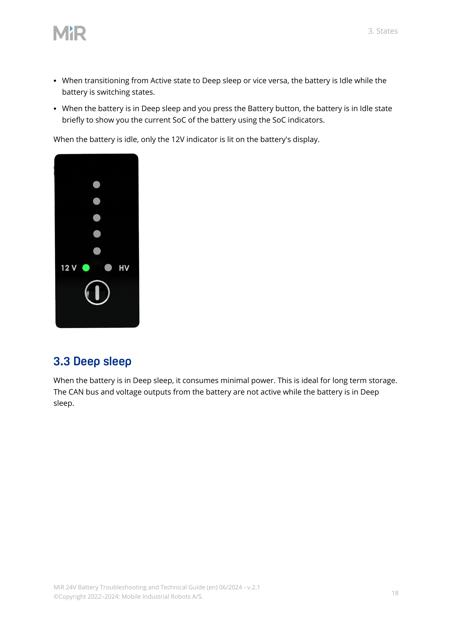
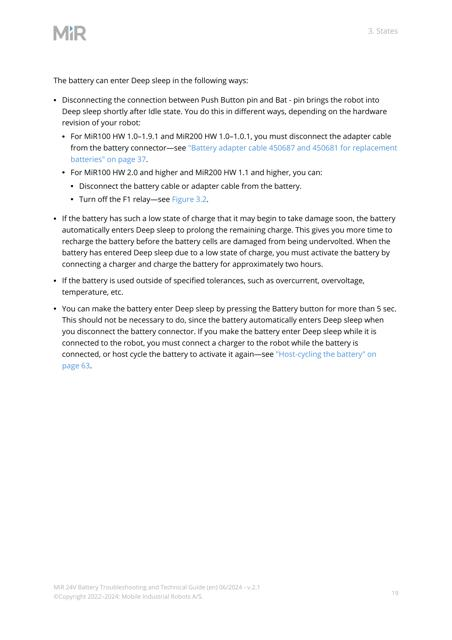
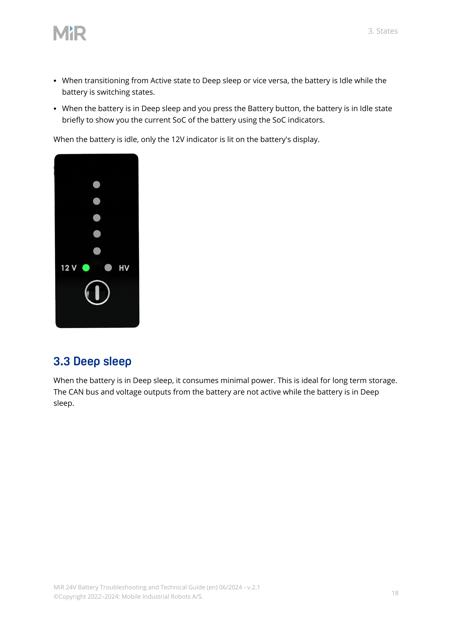
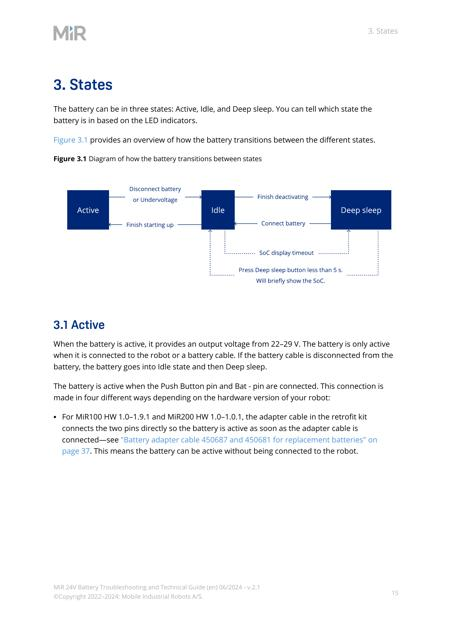
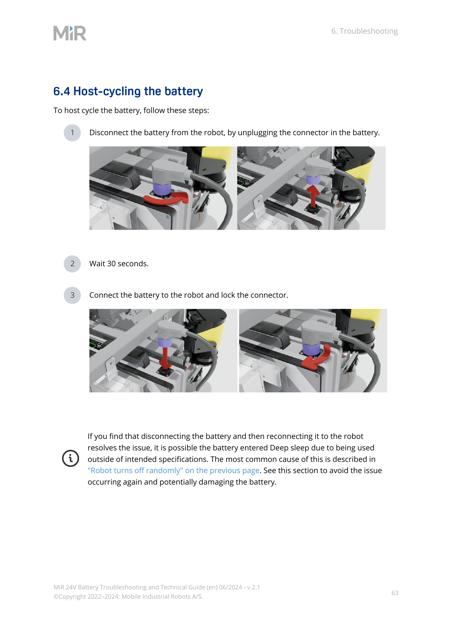
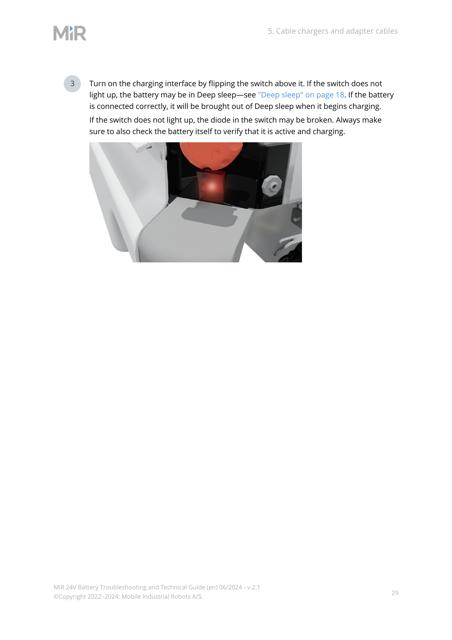

In [ ]:
engine_chunks.inspect_run("Dense & Sparse(DBSF) - OCR")

Button(description='Next Query', style=ButtonStyle())


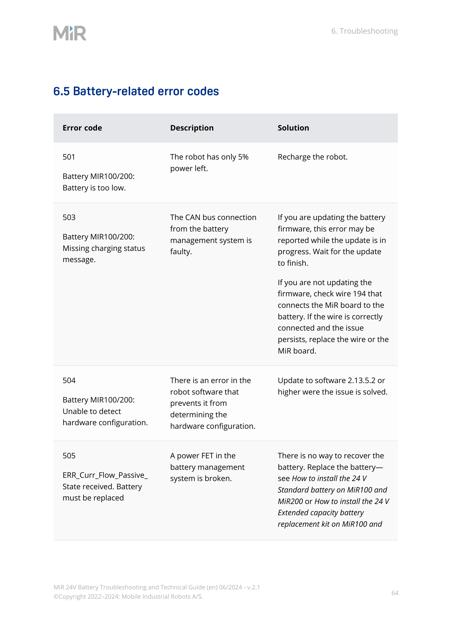
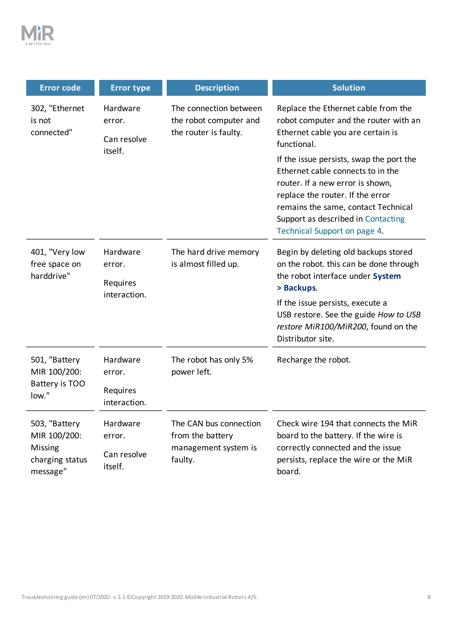
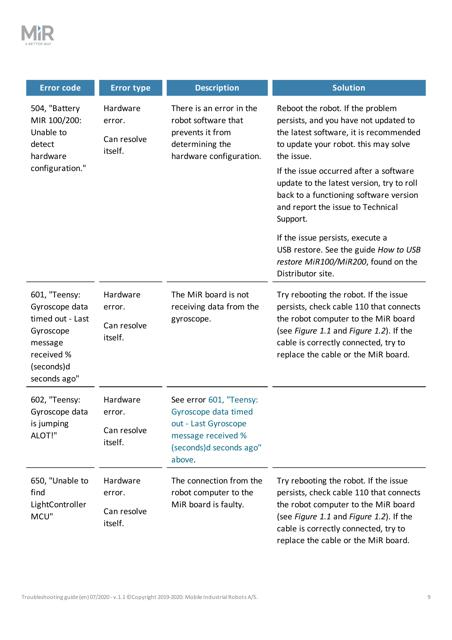
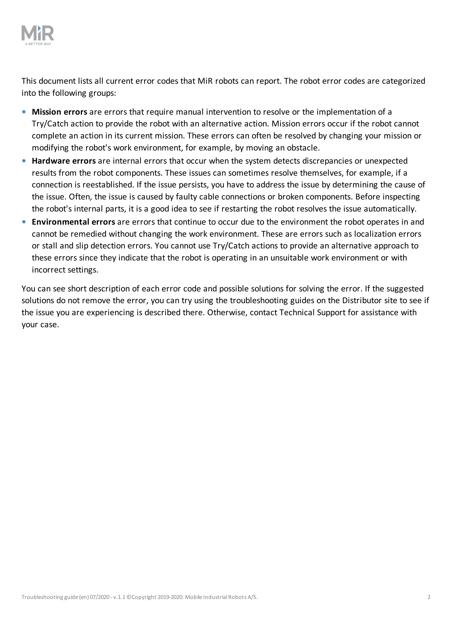
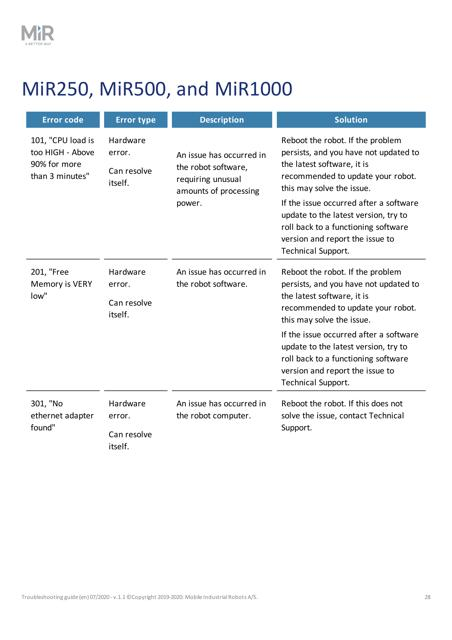
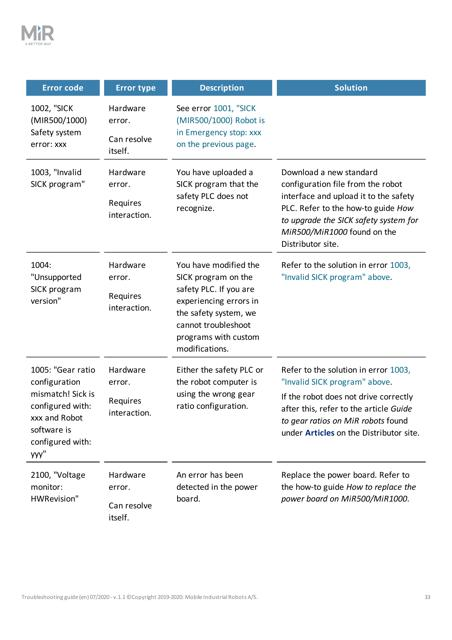

In [ ]:
engine_pages.inspect_run("Dense & Sparse(DBSF) - Markdown")

## Showcasing for any user query and any retrieval pipeline (not at runtime)

In [ ]:
def display_results_for_query(user_query):
    vectors = embed_single_query(user_query)
    qv = QueryVector(
                dense=vectors["dense_vector"],
                sparse=vectors["sparse_vector"],
                query_id=query_id
            )

    scores, payloads = engine_pages.rrf_fusion_search(qv, ["dense", "sparse"])
    display_result(user_query, payloads)

In [ ]:
display_results_for_query("")

## Examples


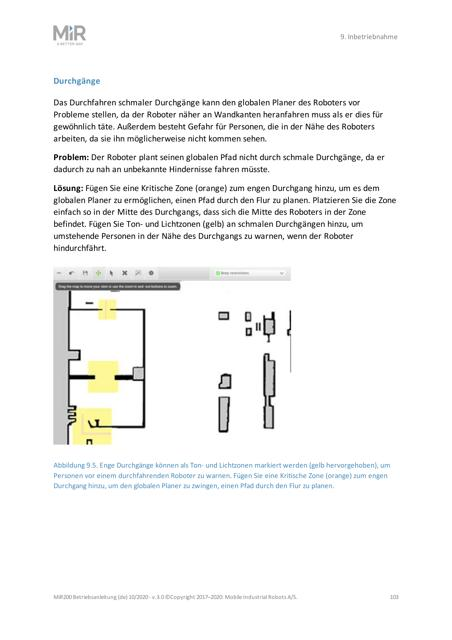
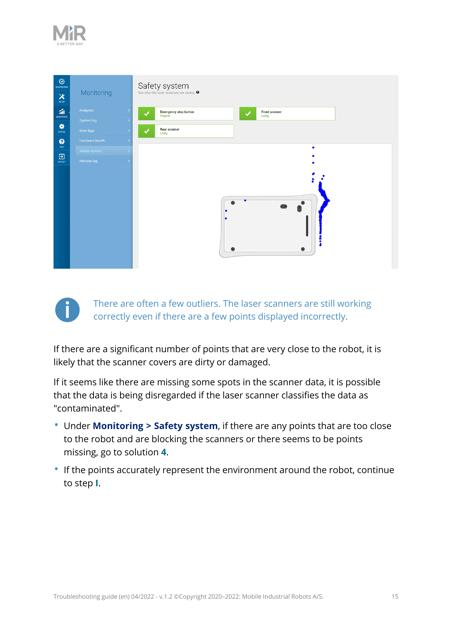
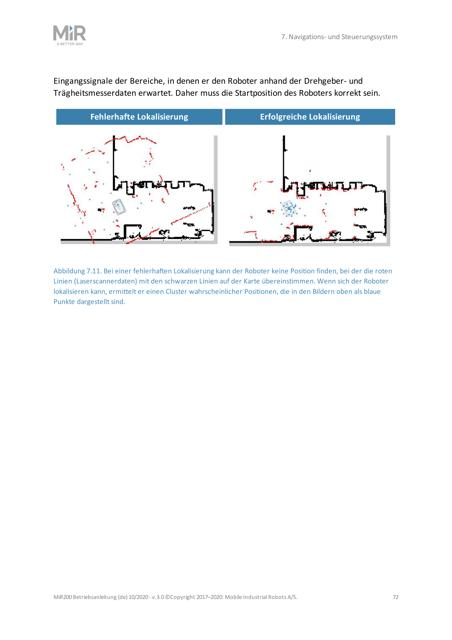
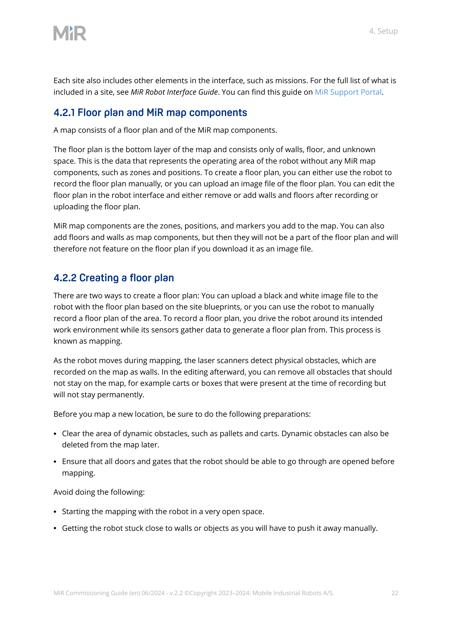
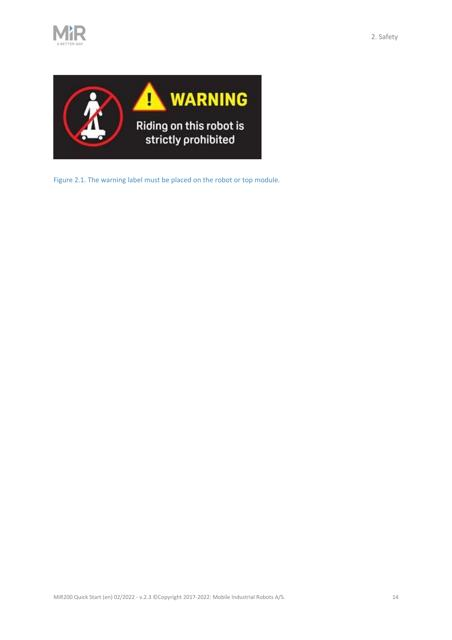

In [ ]:
display_results_for_query("Robot shows warning location accuracy low")


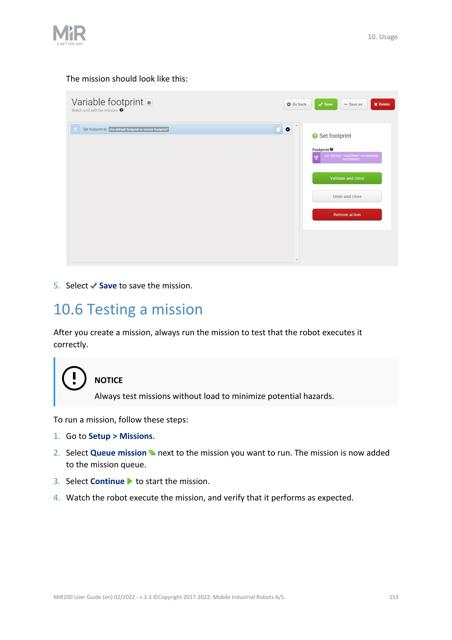
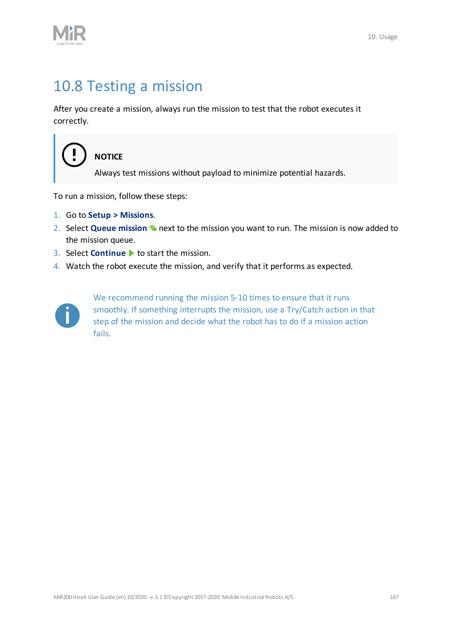
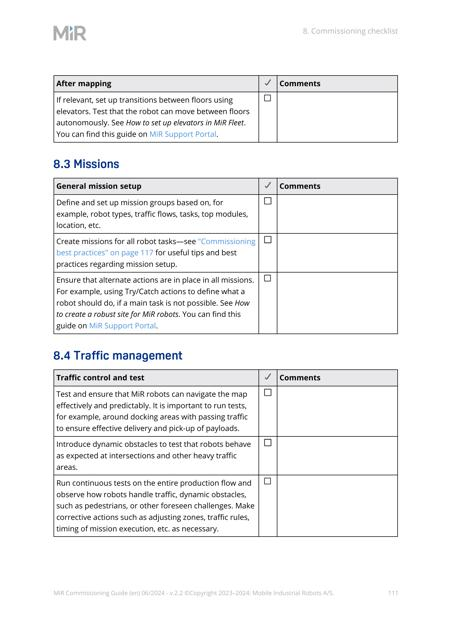
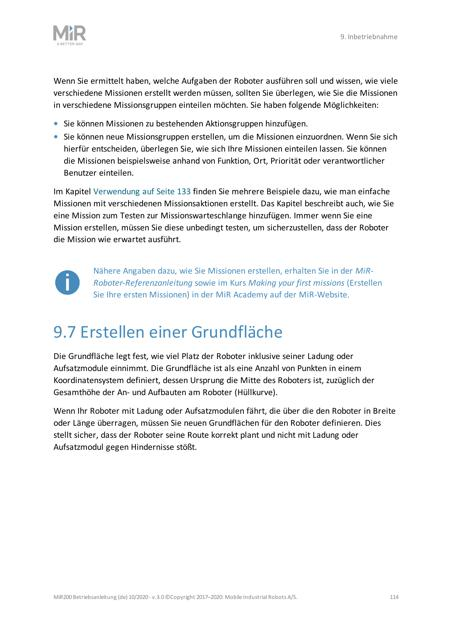
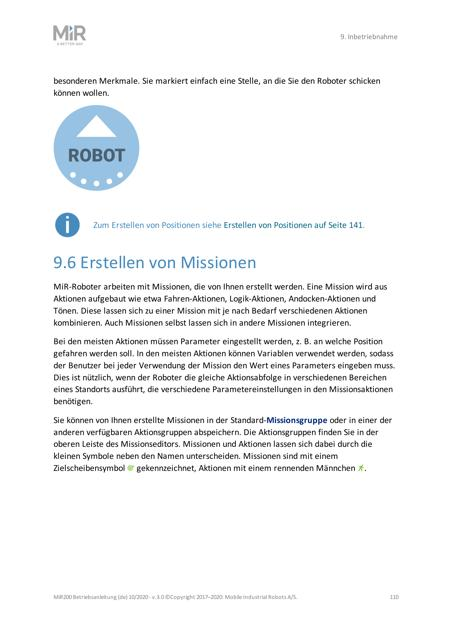

In [ ]:
display_results_for_query("I do not know how to setup a mission")


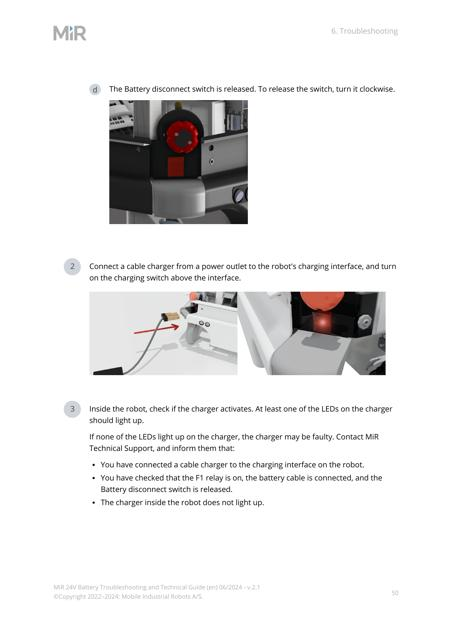
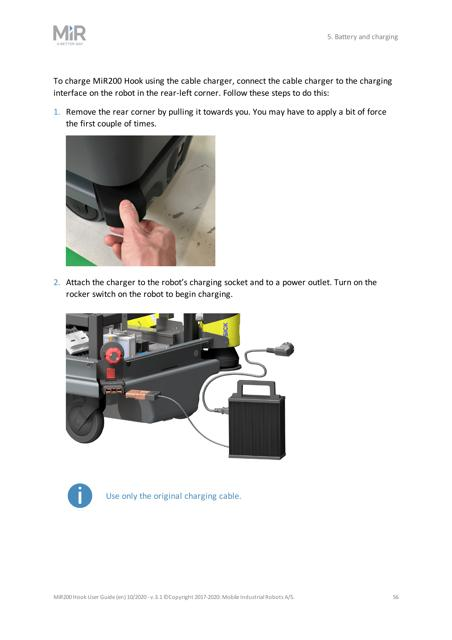
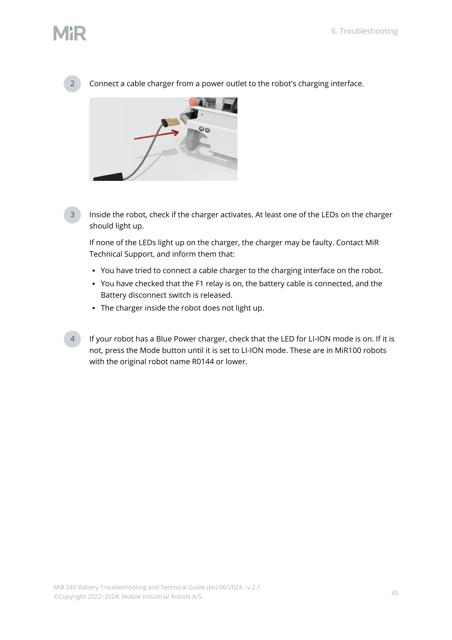
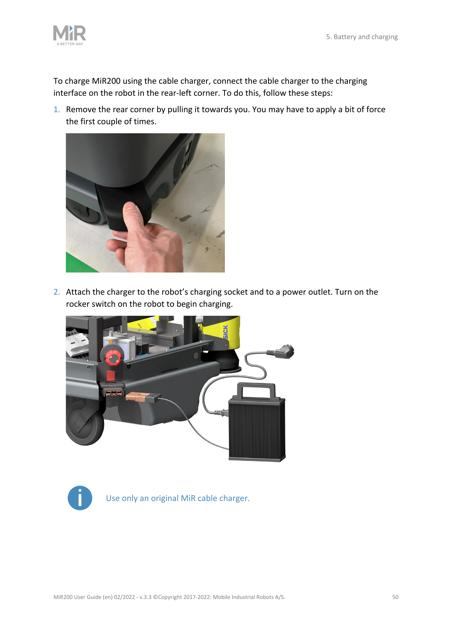
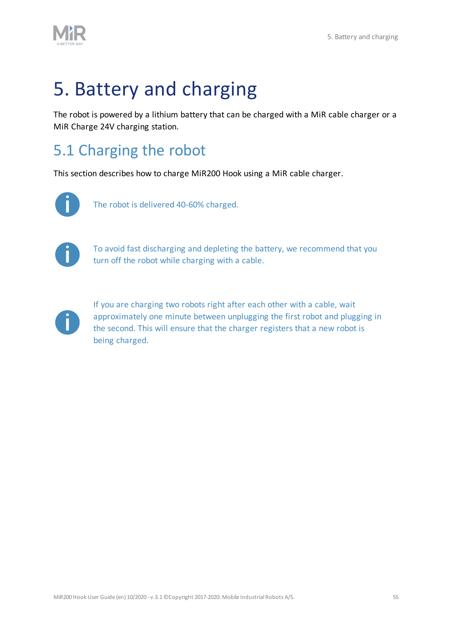

In [ ]:
display_results_for_query("Robot failed to charge")


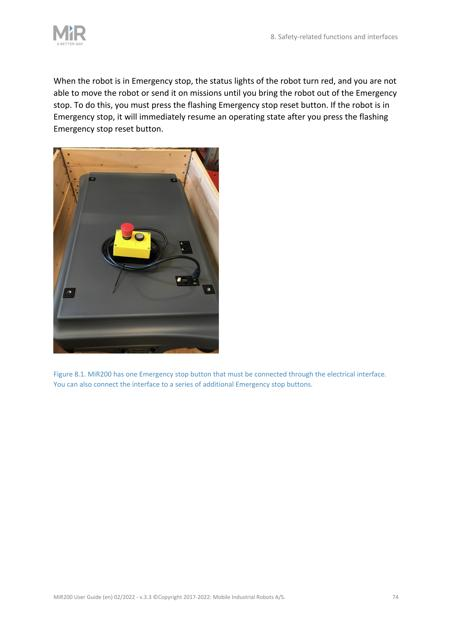
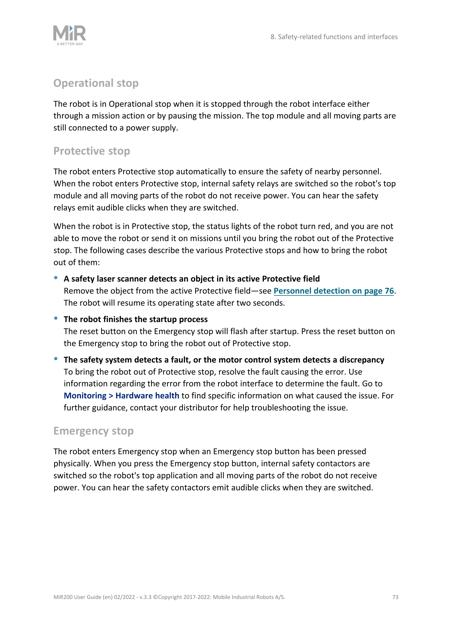
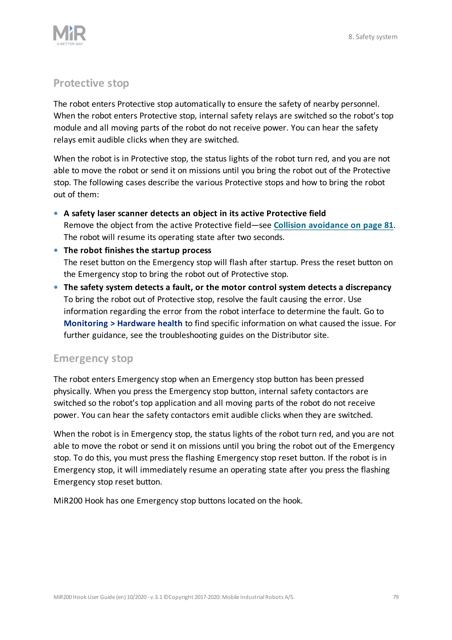
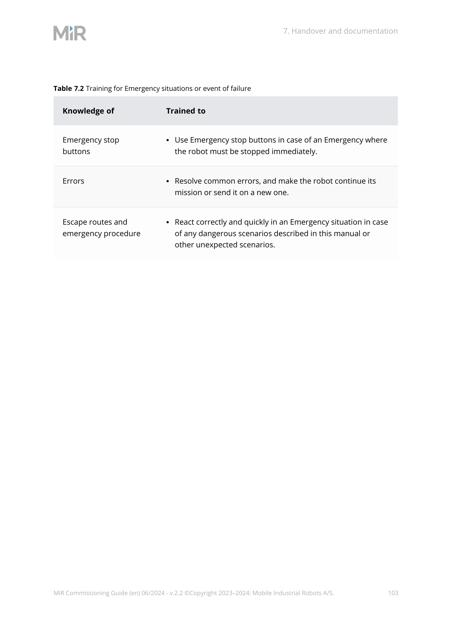
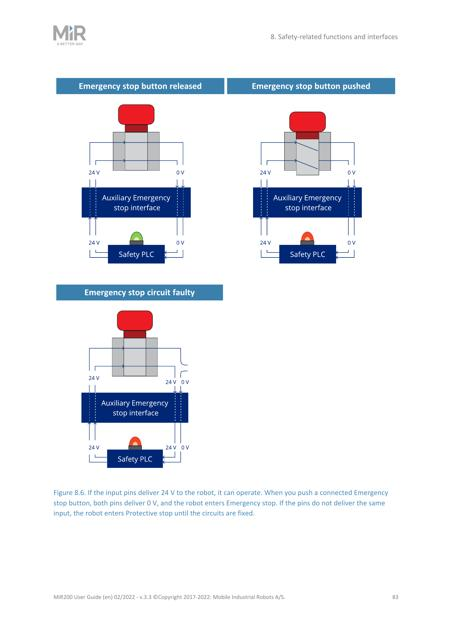

In [ ]:
display_results_for_query("Emergency stop active")


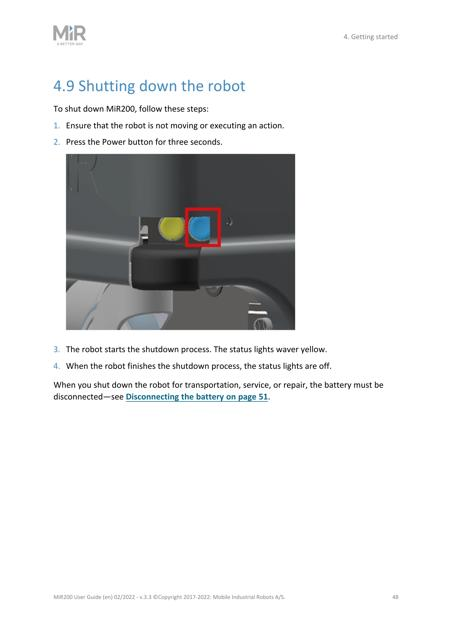
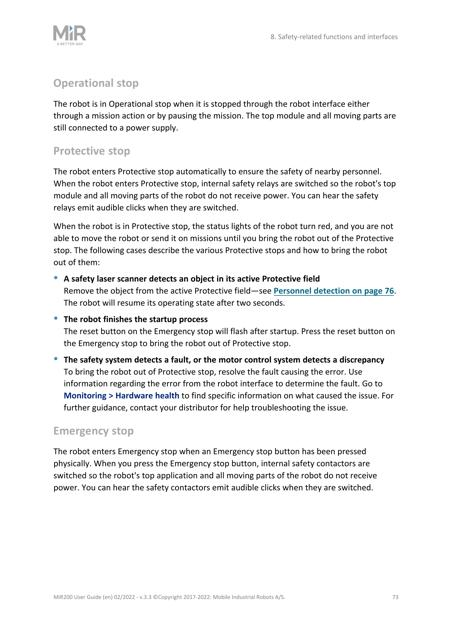
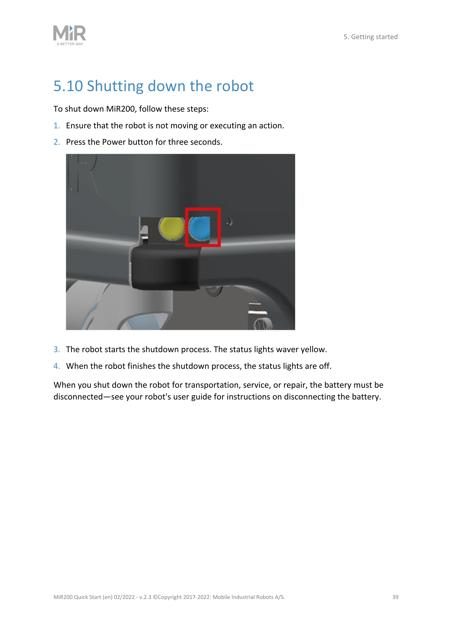
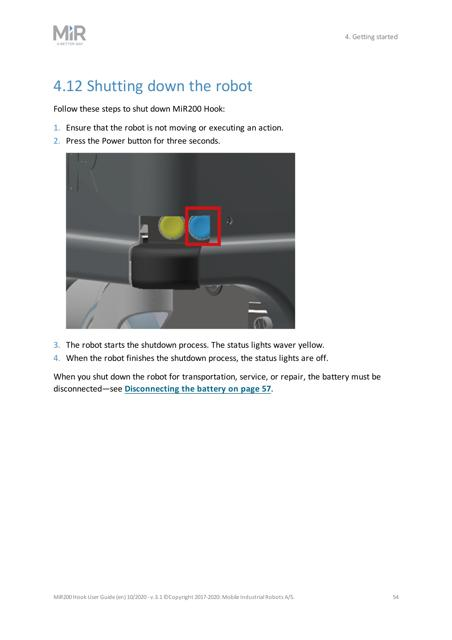
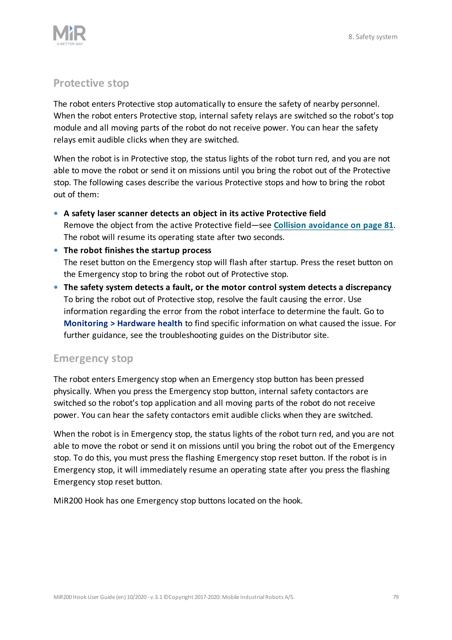

In [ ]:
display_results_for_query("Robot stopped and shut down")


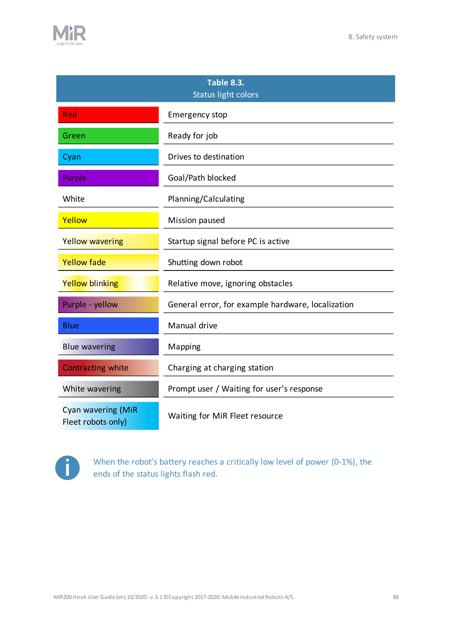
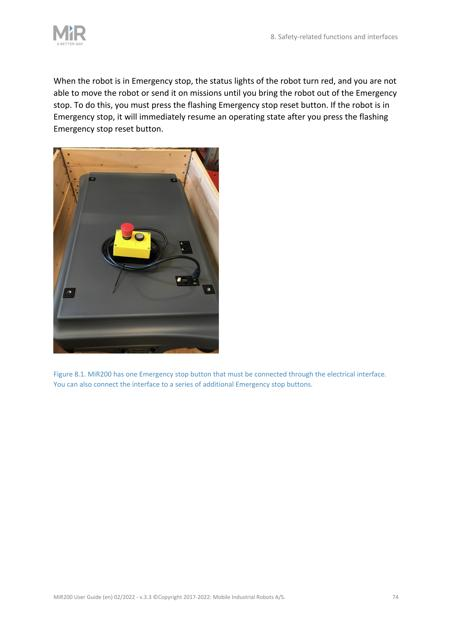
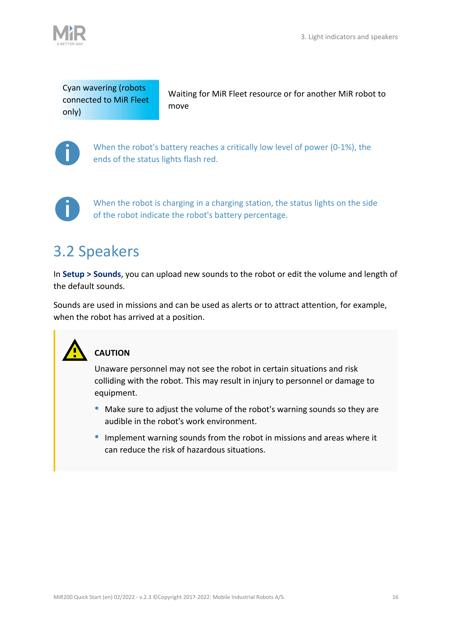
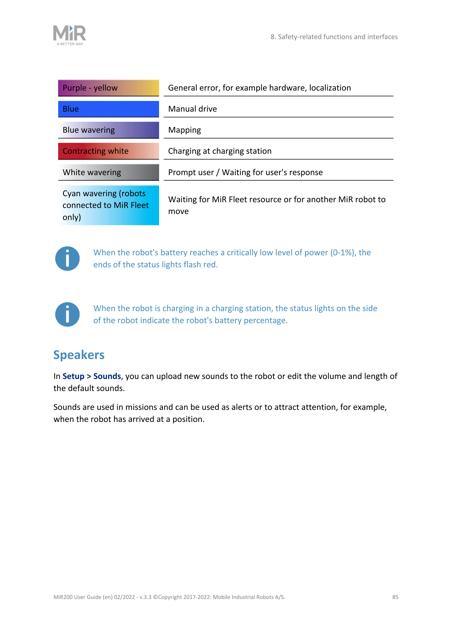
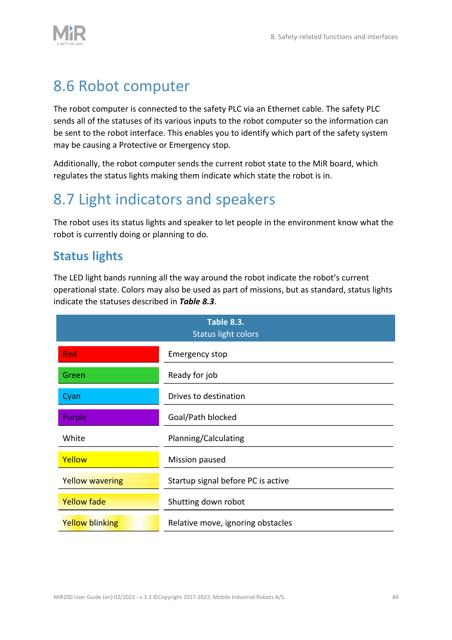

In [ ]:
display_results_for_query("Robot flashes in red")


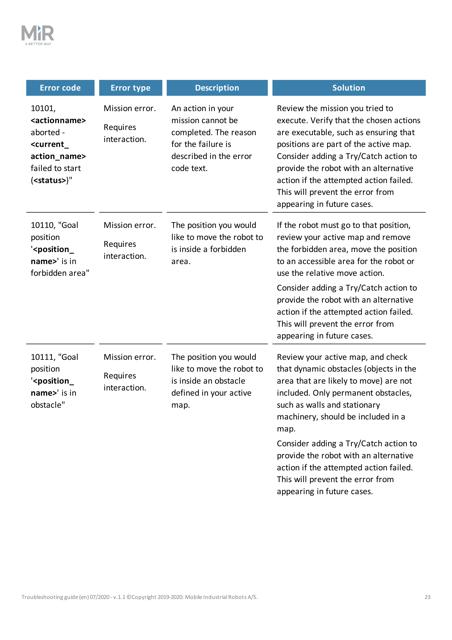
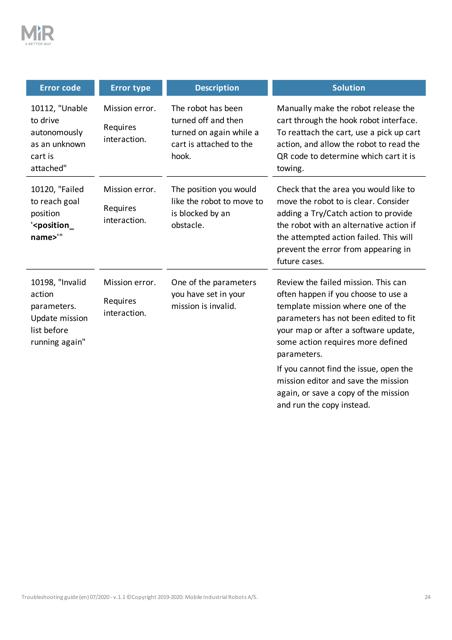
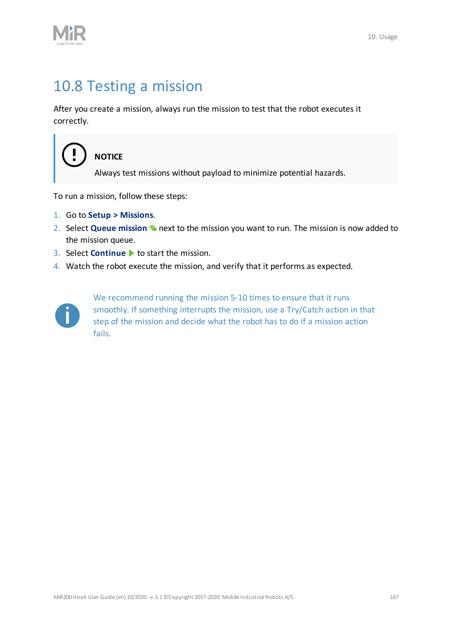
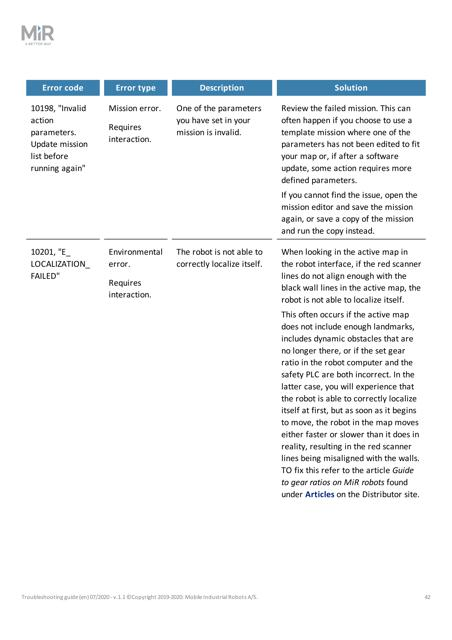
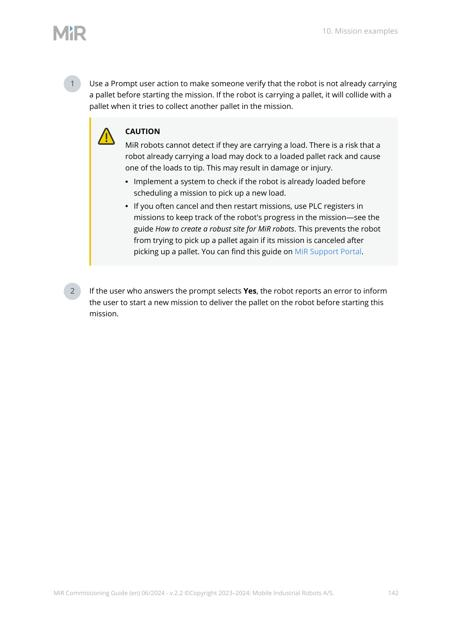

In [ ]:
display_results_for_query("Robot does not start the mission")